## Slice grappa with in plane acceleration
###### Author: Zimu Huo
###### Date: 05.2022

In this case, the sms data is acquired with slice fatctor of ns, and in plane factor of R. To unfold the aliasing, one could arrange the data in the sense/grappa fashion or as two separate steps. Here, the later one is shown. 
<br>
<br> 1. the slice grappa is used to separate the slice
<br> 2. the conventional grappa is then used along with reference data to unfold each individual slice. 


-------------------------------------------------------------------------
References

    [1] 
    Author:  Setsompop K et al. 
    Title: Blipped-controlled aliasing in parallel imaging for simultaneous multislice echo planar imaging with reduced g-factor penalty
    Link: https://onlinelibrary.wiley.com/doi/10.1002/mrm.23097

In [18]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import util.simulator as simulate
from util.coil import *
from util.fft import *
import util.mask as undersample
from util.sg import *
from util.grappa import *

In [34]:
numSlice = 4
R = 8  # sms factor 4, grappa factor 2
slice1 = np.load("../lib/slice1_grappa1.npy")
slice2 = np.load("../lib/slice2_grappa1.npy")
slice3 = np.load("../lib/slice3_grappa1.npy")
slice4 = np.load("../lib/slice4_grappa1.npy")
data = np.concatenate((slice1[...,None], slice2[...,None], slice3[...,None], slice4[...,None]), -1)[...,:numSlice]
rawImage = ifft2c(data)
fovHeight, fovWidth, numCoil, _ = rawImage.shape

In [35]:
rawData = np.zeros(rawImage.shape, dtype = complex)
for sli in range (numSlice):
        rawData[:,:,:,sli] = fft2c(rawImage[:,:,:,sli])

In [36]:
cycle = np.arange(0,1,1/numSlice) * 2* np.pi
numAccq = int(numSlice*fovHeight/R)

In [37]:
shift = cycle*numAccq/(2*np.pi)
dataR = fft2c(simulate.multiSliceCAIPI(rawImage, cycle, R))

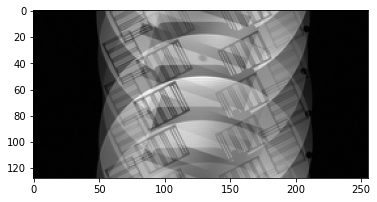

In [38]:
showrsos(ifft2c(dataR))

In [39]:
ncx = 64
ncy = 64
acsshift = cycle*int(numSlice* ncy/R)/(2*np.pi)
acsK = simulate.acs(rawData, (ncy, ncx))
acsK = acsK[::2]
acsIm = ifft2c(acsK)
calib = fft2c(simulate.singleSliceFov(acsIm,acsshift))

In [40]:
recon = sg(dataR,calib)

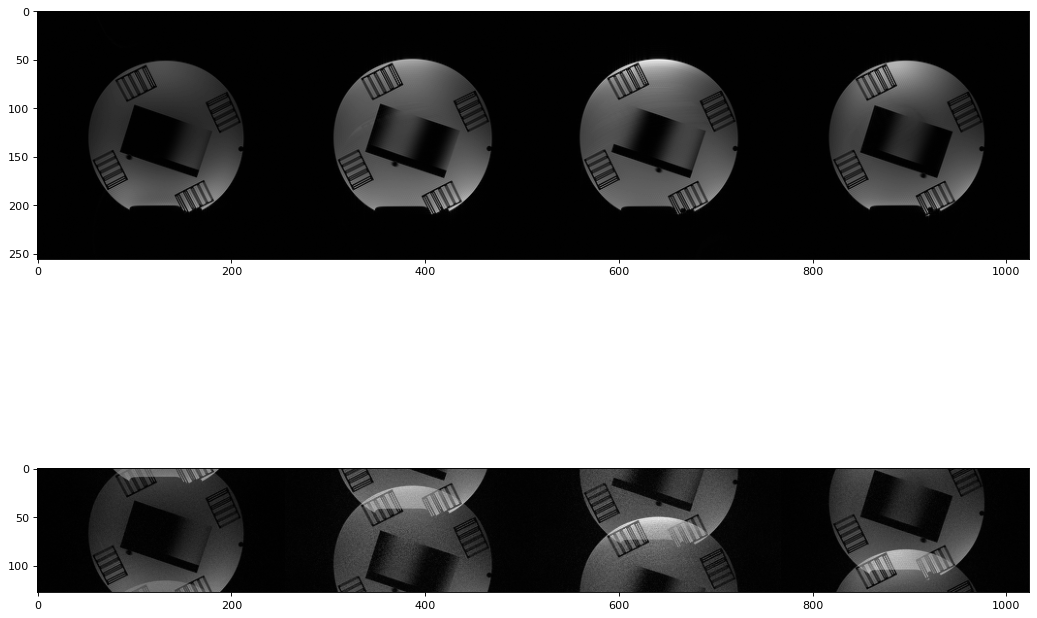

In [ ]:
fig = plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(211)
plt.imshow(np.abs(stitch(rsos(rawImage), 1)), cmap = "gray")
plt.subplot(212)
plt.imshow(np.abs(stitch(rsos(ifft2c(recon)),1)), cmap = "gray")

In [42]:
acsK = simulate.acs(rawData, (32, 32))
acsIm  = ifft2c(acsK)
acsshift = cycle*(32*2/4)/(2*np.pi)
acsIm = simulate.singleSliceFov(acsIm, acsshift)
acs = fft2c(acsIm)

In [43]:
recon2 = np.zeros([fovHeight, fovWidth, numCoil, numSlice], dtype = complex)
for sli in range(numSlice):
    tmp = np.zeros([fovHeight, fovWidth, numCoil], dtype = complex)
    tmp[::2] = recon[...,sli]
    recon2[...,sli] = grappa(tmp, acs[...,sli], combine = False)

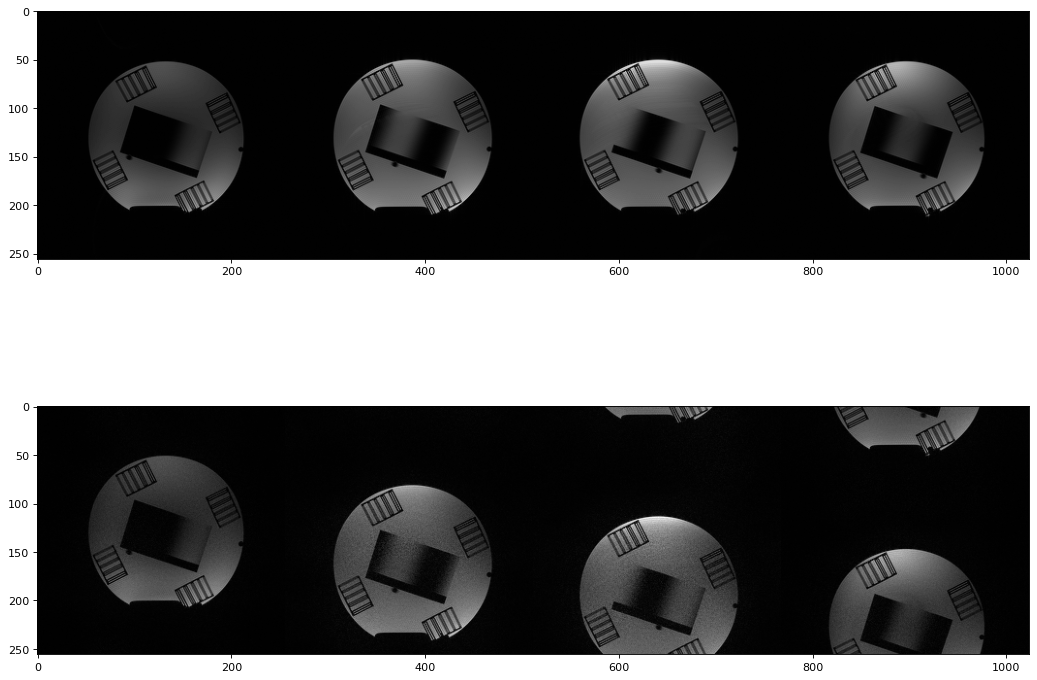

In [45]:
fig = plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(211)
plt.imshow(np.abs(stitch(rsos(rawImage), 1)), cmap = "gray")
plt.subplot(212)
plt.imshow(np.abs(stitch(rsos((recon2)),1)), cmap = "gray")